In [1]:
%matplotlib inline

In [2]:
%run ../proofs/notebook_setup.py

In [3]:
"""Europa-Io occultation from the PHEMU campaign."""
import numpy as np
from matplotlib import pyplot as plt
from astropy.time import Time
import astropy.units as u
from astropy.timeseries import TimeSeries
from astroquery.jplhorizons import Horizons
import os
import starry
from matplotlib.patches import ConnectionPatch


def get_body_ephemeris(times, body_id="501", step="1m"):

    start = times.isot[0]

    # Because Horizons time range doesn't include the endpoint
    # we need to add some extra time
    if step[-1] == "m":
        padding = 2 * float(step[:-1]) / (60 * 24)
    elif step[-1] == "h":
        padding = 2 * float(step[:-1]) / 24
    elif step[-1] == "d":
        padding = 2 * float(step[:-1])
    else:
        raise ValueError(
            "Unrecognized JPL Horizons step size. Use '1m' or '1h' for example."
        )
    end = Time(times.mjd[-1] + padding, format="mjd").isot

    # Query JPL Horizons
    epochs = {"start": start, "stop": end, "step": step}
    obj = Horizons(id=body_id, epochs=epochs, id_type="id")
    eph = obj.ephemerides(extra_precision=True)
    times_jpl = Time(eph["datetime_jd"], format="jd")

    # Store all data in a TimeSeries object
    data = TimeSeries(time=times)
    data["RA"] = np.interp(times.mjd, times_jpl.mjd, eph["RA"]) * eph["RA"].unit
    data["DEC"] = np.interp(times.mjd, times_jpl.mjd, eph["DEC"]) * eph["DEC"].unit
    data["ang_width"] = (
        np.interp(times.mjd, times_jpl.mjd, eph["ang_width"]) * eph["ang_width"].unit
    )
    data["phase_angle"] = (
        np.interp(times.mjd, times_jpl.mjd, eph["alpha_true"]) * eph["alpha_true"].unit
    )
    eph = obj.ephemerides(extra_precision=True)

    # Boolean flags for occultations/eclipses
    occ_sunlight = eph["sat_vis"] == "O"
    umbra = eph["sat_vis"] == "u"
    occ_umbra = eph["sat_vis"] == "U"
    partial = eph["sat_vis"] == "p"
    occ_partial = eph["sat_vis"] == "P"
    occulted = np.any([occ_umbra, occ_sunlight], axis=0)

    data["ecl_par"] = np.array(
        np.interp(times.mjd, times_jpl.mjd, partial), dtype=bool,
    )
    data["ecl_tot"] = np.array(np.interp(times.mjd, times_jpl.mjd, umbra), dtype=bool,)
    data["occ_umbra"] = np.array(
        np.interp(times.mjd, times_jpl.mjd, occ_umbra), dtype=bool,
    )
    data["occ_sun"] = np.array(
        np.interp(times.mjd, times_jpl.mjd, occ_sunlight), dtype=bool,
    )

    # Helper functions for dealing with angles and discontinuities
    subtract_angles = lambda x, y: np.fmod((x - y) + np.pi * 3, 2 * np.pi) - np.pi

    def interpolate_angle(x, xp, yp):
        """
        Interpolate an angular quantity on domain [-pi, pi) and avoid 
        discontinuities.

        """
        cosy = np.interp(x, xp, np.cos(yp))
        siny = np.interp(x, xp, np.sin(yp))

        return np.arctan2(siny, cosy)

    # Inclination of the starry map = 90 - latitude of the central point of
    # the observed disc
    data["inc"] = interpolate_angle(
        times.mjd, times_jpl.mjd, np.pi / 2 * u.rad - eph["PDObsLat"].to(u.rad),
    ).to(u.deg)

    # Rotational phase of the starry map is the observer longitude
    data["theta"] = (
        interpolate_angle(
            times.mjd, times_jpl.mjd, eph["PDObsLon"].to(u.rad) - np.pi * u.rad,
        ).to(u.deg)
    ) + 180 * u.deg

    # Obliquity of the starry map is the CCW angle from the celestial
    # NP to the NP of the target body
    data["obl"] = interpolate_angle(
        times.mjd, times_jpl.mjd, eph["NPole_ang"].to(u.rad),
    ).to(u.deg)

    # Compute the location of the subsolar point relative to the central
    # point of the disc
    lon_subsolar = subtract_angles(
        np.array(eph["PDSunLon"].to(u.rad)), np.array(eph["PDObsLon"].to(u.rad)),
    )
    lon_subsolar = 2 * np.pi - lon_subsolar  # positive lon. is to the east

    lat_subsolar = subtract_angles(
        np.array(eph["PDSunLat"].to(u.rad)), np.array(eph["PDObsLat"].to(u.rad)),
    )

    # Location of the subsolar point in cartesian Starry coordinates
    xs = np.array(eph["r"]) * np.cos(lat_subsolar) * np.sin(lon_subsolar)
    ys = np.array(eph["r"]) * np.sin(lat_subsolar)
    zs = np.array(eph["r"]) * np.cos(lat_subsolar) * np.cos(lon_subsolar)

    data["xs"] = np.interp(times.mjd, times_jpl.mjd, xs) * u.AU
    data["ys"] = np.interp(times.mjd, times_jpl.mjd, ys) * u.AU
    data["zs"] = np.interp(times.mjd, times_jpl.mjd, zs) * u.AU

    return data


def get_phemu_data(file="data/G20091204_2o1_JHS_0.txt"):
    y, m, d = file[6:10], file[10:12], file[12:14]
    date_mjd = Time(f"{y}-{m}-{d}", format="isot", scale="utc").to_value("mjd")
    data = np.genfromtxt(file)
    times_mjd = date_mjd + data[:, 0] / (60 * 24)
    time, flux, phemu_model = np.vstack([times_mjd, data[:, 1], data[:, 2]])
    return Time(time, format="mjd"), flux, phemu_model


def get_starry_args(time):
    # Ephemeris
    eph_io = get_body_ephemeris(time, step="1m")
    eph_europa = get_body_ephemeris(time, body_id="502", step="1m",)

    # Get occultation parameters
    obl = np.mean(eph_io["obl"].value)
    inc = np.mean(eph_io["inc"].value)
    theta = np.mean(eph_io["theta"].value)
    ro = np.mean((eph_europa["ang_width"] / eph_io["ang_width"]).value)
    rel_ra = (eph_europa["RA"] - eph_io["RA"]).to(u.arcsec) / (
        0.5 * eph_io["ang_width"].to(u.arcsec)
    )
    rel_dec = (eph_europa["DEC"] - eph_io["DEC"]).to(u.arcsec) / (
        0.5 * eph_io["ang_width"].to(u.arcsec)
    )
    xo = -rel_ra.value
    yo = rel_dec.value
    xs = np.mean(eph_io["xs"].value)
    ys = np.mean(eph_io["ys"].value)
    zs = np.mean(eph_io["zs"].value)

    rs = np.sqrt(xs ** 2 + ys ** 2 + zs ** 2)
    xs /= rs
    ys /= rs
    zs /= rs
    
    return inc, obl, xo, yo, dict(theta=theta, ro=ro, xs=xs, ys=ys, zs=zs)

In [4]:
# Grab the PHEMU light curve
time, flux, phemu_model = get_phemu_data()

# A very rough estimate of the errorbars
ferr = 0.02

# Get geometrical parameters
inc, obl, xo0, yo0, kwargs = get_starry_args(time)

In [5]:
import exoplanet
import pymc3 as pm
import theano.tensor as tt

In [6]:
with pm.Model() as model:

    # Instantiate a starry map & get geometrical parameters
    map = starry.Map(ydeg=15, reflected=True)
    map.inc = inc
    map.obl = obl

    # Load the Galileo SSI / Voyager composite
    # https://astrogeology.usgs.gov/search/map/Io/
    # Voyager-Galileo/Io_GalileoSSI-Voyager_Global_Mosaic_1km
    map.load("data/io_mosaic.jpg")

    # Free parameters
    dx = pm.Uniform("dx", lower=-0.5, upper=0.5, testval=0.0)
    dy = pm.Uniform("dy", lower=-0.5, upper=0.5, testval=0.0)
    amp = pm.Uniform("amp", lower=0.01, upper=100.0, testval=1.0)
    europa_amp = pm.Uniform("europa_amp", lower=0.3, upper=0.7, testval=0.50)
    roughness = pm.Uniform("roughness", lower=0.0, upper=60.0, testval=5.0)

    # Compute the flux model
    map.roughness = roughness
    flux_model = europa_amp + amp * map.flux(
        xo=tt.as_tensor_variable(xo0) + dx, yo=tt.as_tensor_variable(yo0) + dy, **kwargs
    )

    # Track some values for plotting later
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = exoplanet.eval_in_model(flux_model)

    # The likelihood function
    pm.Normal("obs", mu=flux_model, sd=ferr, observed=flux)

Pre-computing some matrices... Done.
Compiling `P`... Done.


In [7]:
with model:
    map_soln = exoplanet.optimize()

optimizing logp for variables: [roughness, europa_amp, amp, dy, dx]


message: Desired error not necessarily achieved due to precision loss.
logp: -69701.38446253687 -> 1192.9210326968564


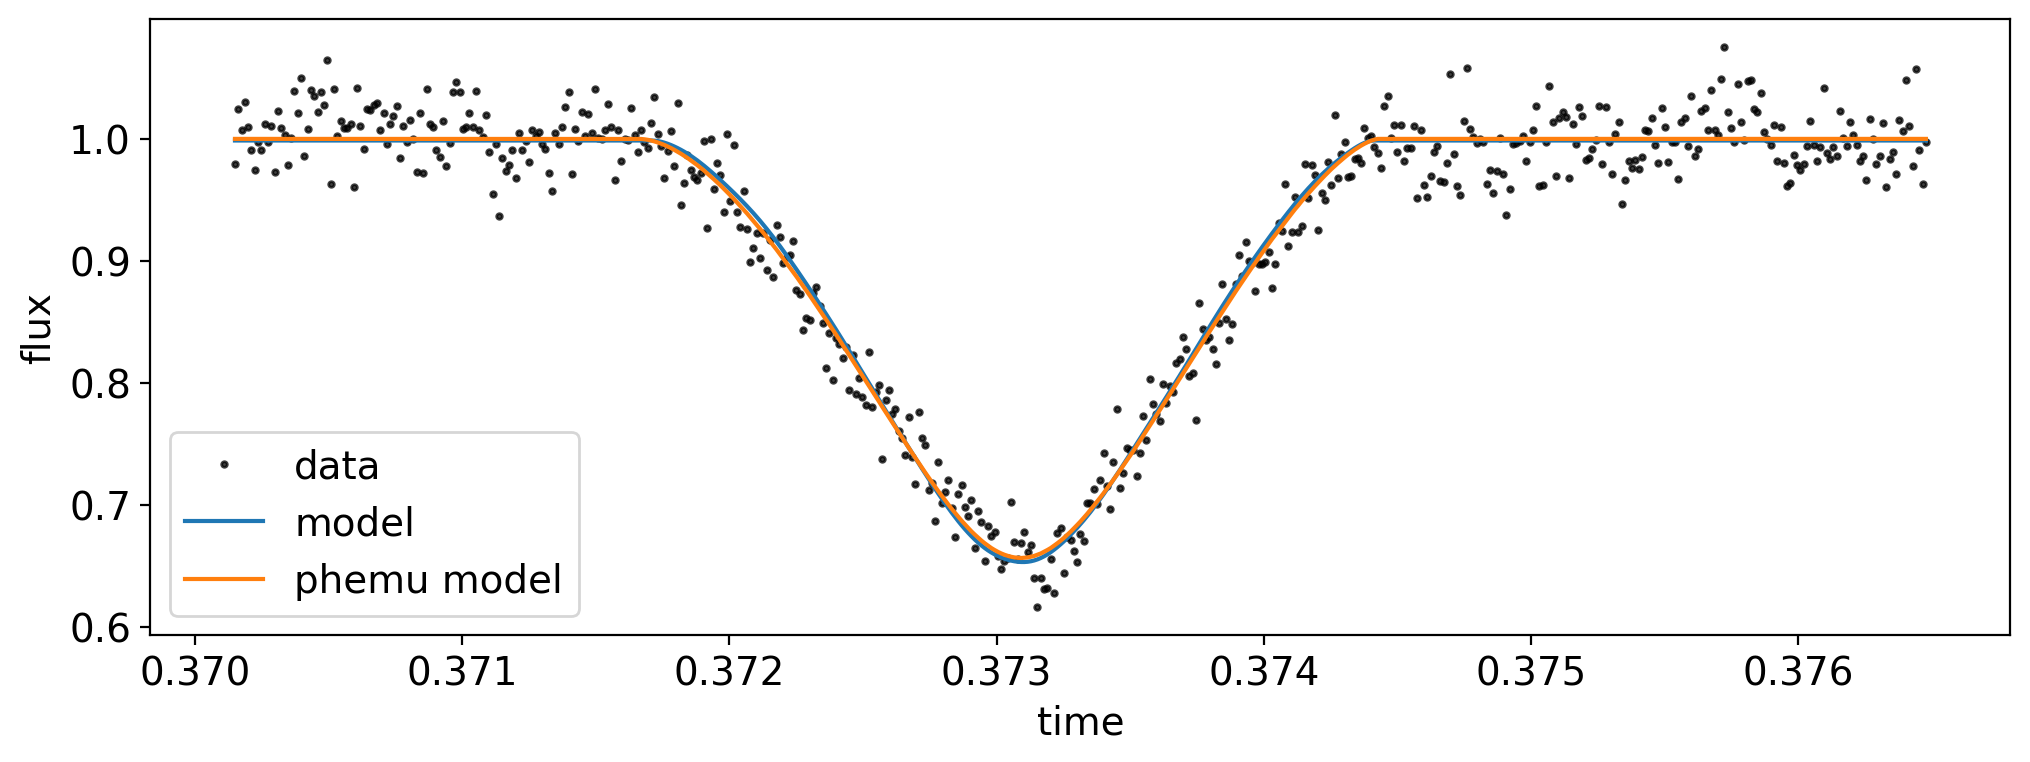

In [8]:
t = time.value - 55169
plt.plot(t, flux, "k.", alpha=0.75, ms=4, label="data")
plt.plot(t, map_soln["flux_model"], label="model")
plt.plot(t, phemu_model, label="phemu model")
plt.xlabel("time")
plt.ylabel("flux")
plt.legend();

In [9]:
for param in ["dx", "dy", "amp", "europa_amp", "roughness"]:
    print("{} = {}".format(param, map_soln[param]))

dx = 0.0647932578523498
dy = 0.0058688258741125265
amp = 4.949347231812881
europa_amp = 0.4686696569790987
roughness = 55.730510061534986


Compiling `render`... Done.


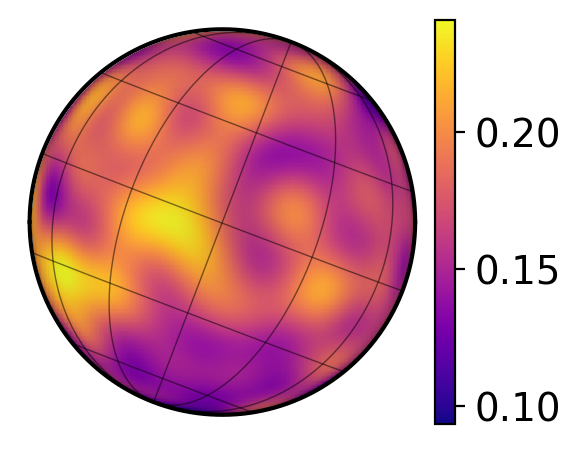

In [10]:
map.show(colorbar=True, model=model, point=map_soln)